# Example 1 -- noiseless $C$ and $K$

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf
import seaborn as sns
from simulation_v1 import *
from train_v1 import theoretical_C_K_obs
from estim_v1 import Optim_tf

from tick.hawkes import HawkesCumulantMatching
from tick.hawkes.inference.base import LearnerHawkesNoParam

from functions import compute_skew

import sys
sys.path.append('/home/users/ruan/ANotebook/spread/Models')
from dump_load import DataBox

In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
#parameters setting
alpha = np.array([[0.1, 0.3, 0.1, 0], 
                  [0.3, 0., 0.1, 0.2],
                  [0.1, 0.1, 0, 0.3],
                  [0, 0.1, 0.2, 0.1]])
beta = 20

mu_tot = 1
#r is the proportion of exogenous order
r = 0.6
mu = (1-r) * mu_tot * np.ones((4))
lam = r * mu_tot * np.ones((2))
delay = 0.05
T = 2000
n_realizations = 20

print(np.linalg.eig(alpha)[0])

[ 0.49595141  0.18021064 -0.30207779 -0.17408426]


In [6]:
norm_phi = alpha
R = np.linalg.inv(np.eye(4) - norm_phi)
lamlam = np.concatenate((lam, lam))
Lp = R @ (mu + lamlam) # Lp[1] is the \Lambda price1+ process, sum of two processes
C = R @ (np.diag(Lp) + np.kron(np.array([[0,1],[1,0]]), np.diag(lam))) @ R.T

hawkes_to_price = np.array([[1, -1, 0, 0], [0, 0, 1, -1]])
Lam_price = np.array([[1, 1, 0, 0], [0, 0, 1, 1]]) @ Lp
C_price = hawkes_to_price @ C @ hawkes_to_price.T
correl_price = C_price[0,1] / np.sqrt(C_price[0,0] * C_price[1,1])
print('Cov micro:', Lam_price)
print('Cov macro:', C_price)
## print('Corrélation:', correl_price)

Cov micro: [4.22035776 3.74544879]
Cov macro: [[2.9567275  1.15122286]
 [1.15122286 2.71649894]]


In [21]:
## theorical C and K values
L_thr = tf.convert_to_tensor(Lp)
C_thr, K_thr = theoretical_C_K_obs(Lp, lamlam, R, only_ijj=True)

## simulation

In [22]:
simulating = False

In [23]:
if simulating :
    times = []
    for i in tqdm(range(n_realizations)):
        ns, hs = generate_hawkes_with_noise(μ=mu, α=alpha, β=beta, T=T, ν=lam, γ=delay)
        times.append(from_mark_to_timestamps(ns, hs))
    dic = {'alpha' : alpha, 'beta' : beta,
      'mu':mu, 'lam_x':lam, 'T':T, 'delay':delay,
      'data':times}
    db = DataBox('./run/simulation')
    db.save_pickles(dic, 'ogata_simu_6.pkl')
    

## estimated C and K from data

In [24]:
estimating = False
if estimating:
    db = DataBox('./run/simulation')
    dic = db.load_pickles('clust_simu_6.pkl')
    times = dic['data']
    for i in range(100):
        for j,ts in enumerate(times[i]):
            times[i][j] = np.array(ts)

In [25]:
if estimating : 
    integration_support = 1 # H 
    nphc = HawkesCumulantMatching(integration_support, 
                                  cs_ratio=.15, 
                                  tol=1e-10, 
                                  step=0.3)
    LearnerHawkesNoParam.fit(nphc, times, end_times=np.ones(len(times))*T)
    cumcal = nphc._cumulant_computer
    # estimate moments tick
    # estimator Λ
    cumcal.compute_L()
    L_est = cumcal.L
    # estimator C
    cumcal.compute_C_and_J()
    C_est = cumcal.C
    # estimator K
    K_est = compute_skew(cumcal)

In [26]:
if estimating :
    print(L_est, Lp)
    print(C_est, C_thr)    
    print(tf.linalg.diag_part(K_est))

## optimization

In [27]:
opt = Optim_tf(4)

### using theoretical value
L_obs = tf.convert_to_tensor(L_thr)
C_obs = tf.convert_to_tensor(C_thr)
K_obs = tf.convert_to_tensor(K_thr)
opt.set_L_C_K(L_obs, C_obs, K_obs)

0.8940205827921764


In [28]:
# C_obs, K_obs

In [29]:
opt.set_init_value()
opt.set_variables()

[ 0.27103921 -0.05561173 -0.00618941  0.11127682]


In [30]:
opt.variables

[<tf.Variable 'R:0' shape=(4, 4) dtype=float64, numpy=
 array([[1.02787364, 0.05299902, 0.07745906, 0.05297661],
        [0.06861662, 1.05563048, 0.13502512, 0.07681643],
        [0.04284085, 0.18815511, 1.20985085, 0.05080822],
        [0.00856409, 0.12416275, 0.03096539, 1.14483736]])>,
 <tf.Variable 'L:0' shape=(2,) dtype=float64, numpy=array([1., 1.])>]

In [31]:
opt.train(print_every=500, n_iter=5000)

Iter:  500
Loss:  54.70791159466761
Iter:  1000
Loss:  18.06353715570792
Iter:  1500
Loss:  8.23433367878934
Iter:  2000
Loss:  3.960487342973239
Iter:  2500
Loss:  1.6698275518909431
Iter:  3000
Loss:  0.603499032077458
Iter:  3500
Loss:  0.2220793512810246
Iter:  4000
Loss:  0.10886662457582807
Iter:  4500
Loss:  0.06579312234827256
Iter:  5000
Loss:  0.03855430582532892


[<tf.Variable 'R:0' shape=(4, 4) dtype=float64, numpy=
 array([[1.27231581, 0.41860447, 0.20548398, 0.15101736],
        [0.41935927, 1.18201101, 0.23623417, 0.33538506],
        [0.19641832, 0.20875978, 1.12827434, 0.41920787],
        [0.09567096, 0.17785565, 0.27874877, 1.24151341]])>,
 <tf.Variable 'L:0' shape=(2,) dtype=float64, numpy=array([0.60028091, 0.60027434])>]

<AxesSubplot:>

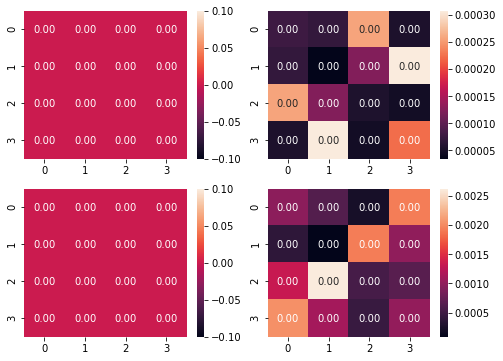

In [40]:
opt.reconstruct_C_K()
fig, axes = plt.subplots(2,2,figsize=(8,6))
sns.heatmap(np.abs(C_thr-opt.C_obs), ax=axes[0,0],annot=True, fmt='.2f')
sns.heatmap(np.abs(opt.C_obs-opt.C_opt), ax=axes[0,1],annot=True, fmt='.2f')
# sns.heatmap(opt.C_opt, ax=axes[0,2],annot=True, fmt='.2f')
sns.heatmap(np.abs(K_thr-opt.K_obs), ax=axes[1,0],annot=True, fmt='.2f')
sns.heatmap(np.abs(opt.K_obs-tf.linalg.diag_part(opt.K_opt)), ax=axes[1,1],annot=True, fmt='.2f')

<AxesSubplot:>

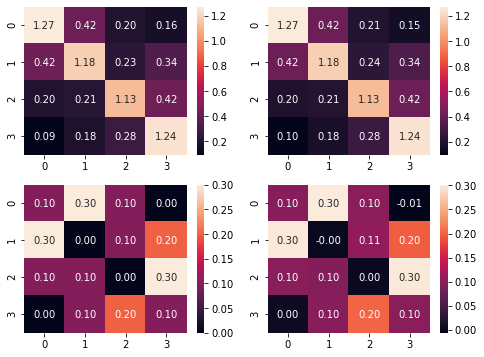

In [41]:

fig, axes = plt.subplots(2,2,figsize=(8,6))
sns.heatmap(R, ax=axes[0,0],annot=True, fmt='.2f')
sns.heatmap(opt.R_opt, ax=axes[0,1],annot=True, fmt='.2f')
sns.heatmap(alpha, ax=axes[1,0],annot=True, fmt='.2f')
sns.heatmap(opt.phi_opt, ax=axes[1,1],annot=True, fmt='.2f')